In [788]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import re
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import spearmanr
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing as pp
from scipy.signal import argrelextrema
from sklearn.metrics import r2_score

### 1. Load all files

In [789]:
# Group Bigrams by Date and Stemmed_Bigram
df = pd.read_csv('/Users/mac/Desktop/Coffee_Bigram.csv')
df['Date'] = pd.to_datetime(df.Date)
df['Frequency'] = df["Percentage"]
df_coffee = df.groupby(['Date','Stemmed_Bigram'])['Frequency'].agg("sum").reset_index()
df_coffee.sort_values(['Date','Frequency'],ascending=(True,False)).reset_index(drop = True)

,Date,Stemmed_Bigram,Frequency
0,2020-10-25,coffe maker,0.267293
1,2020-10-25,coffe tabl,0.113248
2,2020-10-25,coffe grinder,0.055782
3,2020-10-25,coffe mug,0.047522
4,2020-10-25,coffe machin,0.040634
...,...,...,...
268832,2022-05-22,water wine,0.000000
268833,2022-05-22,water women,0.000000
268834,2022-05-22,wine wine,0.000000
268835,2022-05-22,wine women,0.000000


In [790]:
#Load the Coffee Bigrams Chosen by Epoca Team
bigrams = pd.read_csv('/Users/mac/Desktop/Bigrams_Coffee_Epoca.csv')
bigrams = bigrams['Stemmed_Bigram'].tolist()
bigrams

['coffe maker',
 'coffe mug',
 'coffe grinder',
 'coffe machin',
 'coffe glass',
 'brew coffe',
 'mug travel',
 'coffe pour',
 'coffe set',
 'coffe cold',
 'brew cold',
 'coffe ice',
 'coffe pour',
 'french press',
 'coffe press',
 'percol pot',
 'brewer coffe',
 'dripper pour',
 'brew oxo',
 'brewer cold',
 'chemex pour',
 'brew toddi',
 'bodum coffe',
 'brew nitro',
 'cold nitro',
 'brew burk',
 'burk cold',
 'brew primula',
 'cold primula',
 'coffe cold',
 'cold maker',
 'brew machin',
 'bodum cold']

### 2. Functions to Detect Patterns

In [586]:
# Pattern 1: Strictly Above the Threshold
def pattern1(epoca_list, threshold):
    if min(epoca_list) >= threshold:
        return "√"
    else:
        return " "

In [748]:
# Pattern 2: Notable Trend 
def pattern2(lst):
    count_o = count_p = count_m = count_O = count_P = count_M =0
    for i in range(0,int(len(lst)/3*2)):  
        if lst[i] == "o": 
            count_o = count_o+1
        elif lst[i] == "+":
            count_p = count_p+1
        else:
            count_m = count_m+1
    
    for i in range(len(lst)-1, int(len(lst)/3*1),-1):
        if lst[i] == "o": 
            count_O = count_O+1
        elif lst[i] == "+":
            count_P = count_P+1
        else:
            count_M = count_M+1

    if count_o >= int(len(lst)*0.3) and count_P > int(len(lst)/8) and count_M <= int(len(lst)/8):
        return "√"
    else: 
        return ""

In [787]:
# Pattern 3: Declining Trend
def pattern3(slope,intercept,pvalue,rsquare):
    if slope<0  and intercept > 0 and pvalue <  0.05 and rsquare>0.2:
        return '√'
    else: return ""

In [590]:
# Pattern 4: Peak Trend
def pattern4(a,b):
    Frequency = np.array(a)

    #peak
    peak = argrelextrema(Frequency, np.greater)        
    c = len(peak[0][Frequency[peak[0]] >= max(b)*2])

    #valley
    valley = argrelextrema(Frequency, np.less)        
    d = len(valley[0][Frequency[valley[0]] < max(b)*3/4])
    
    if 0 <c <int(len(a)*0.03) and d >= int(len(a)*0.1):
        return '√'
    else: return ""

### 3. Year 2020-2022

In [591]:
#Filter out all the Epoca chosen bigrams.
df_1 = [df_coffee[df_coffee['Stemmed_Bigram'] == bigrams[i]] for i in range(len(bigrams))]
df_1

[             Date Stemmed_Bigram  Frequency
 1313   2020-10-25    coffe maker   0.267293
 4552   2020-11-01    coffe maker   0.254987
 7791   2020-11-08    coffe maker   0.262136
 11030  2020-11-15    coffe maker   0.283564
 14269  2020-11-22    coffe maker   0.302151
 ...           ...            ...        ...
 253955 2022-04-24    coffe maker   0.271241
 257194 2022-05-01    coffe maker   0.259176
 260433 2022-05-08    coffe maker   0.247487
 263672 2022-05-15    coffe maker   0.248981
 266911 2022-05-22    coffe maker   0.259538
 
 [83 rows x 3 columns],
              Date Stemmed_Bigram  Frequency
 1355   2020-10-25      coffe mug   0.047522
 4594   2020-11-01      coffe mug   0.049520
 7833   2020-11-08      coffe mug   0.068591
 11072  2020-11-15      coffe mug   0.062042
 14311  2020-11-22      coffe mug   0.066687
 ...           ...            ...        ...
 253997 2022-04-24      coffe mug   0.029091
 257236 2022-05-01      coffe mug   0.038110
 260475 2022-05-08      coffe

### 3.1 Plot Trendlines

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/3531254627.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,5))


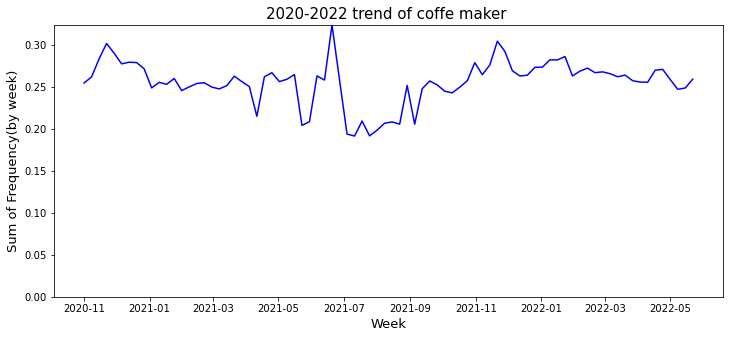

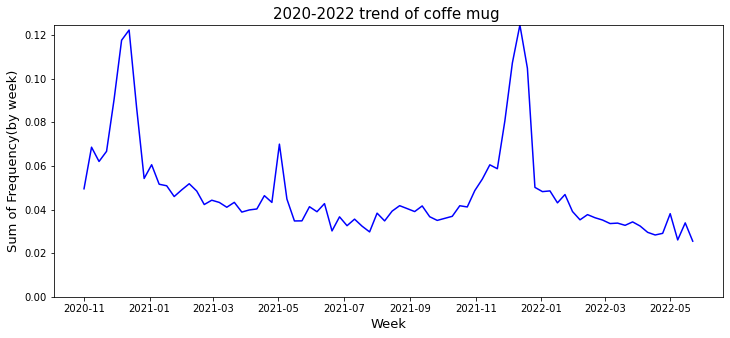

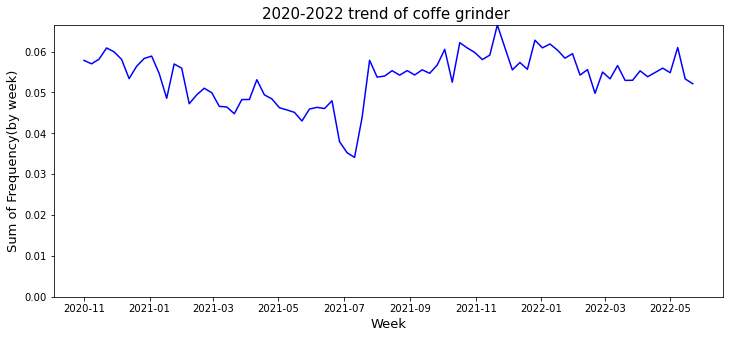

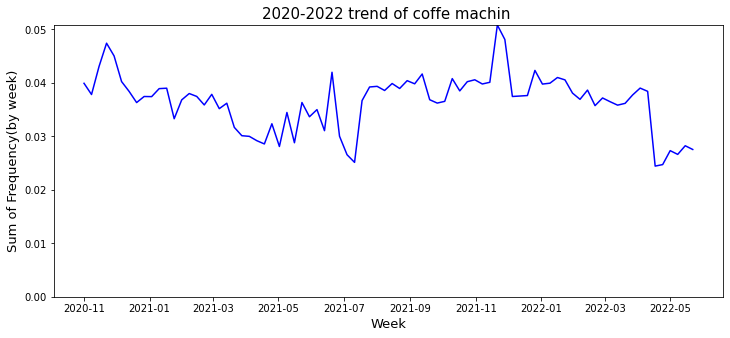

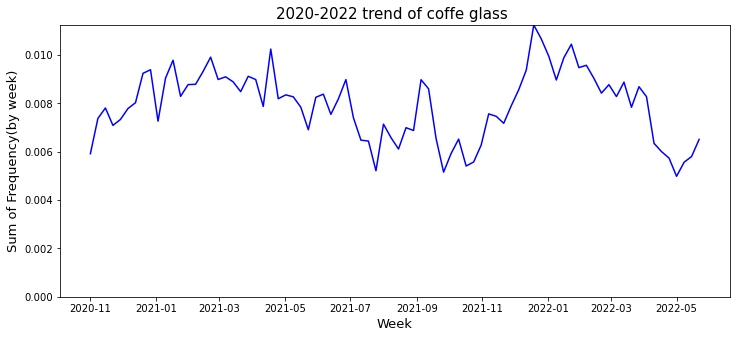

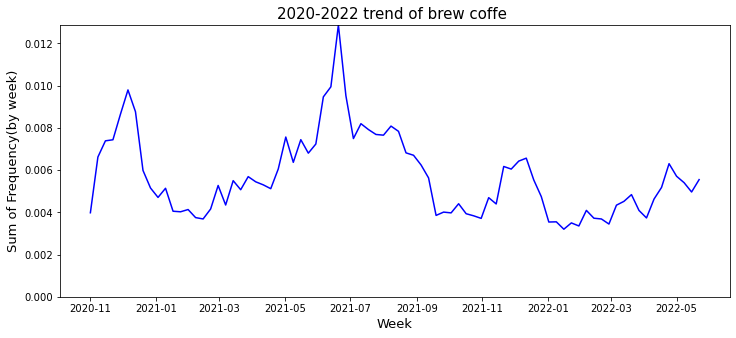

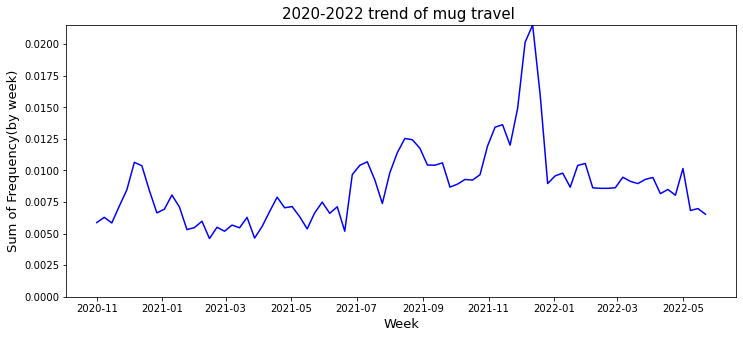

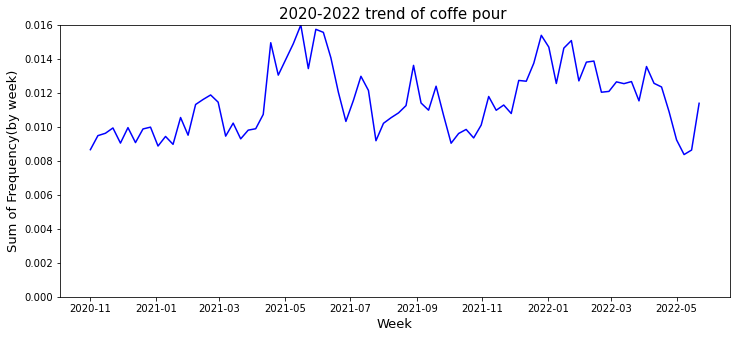

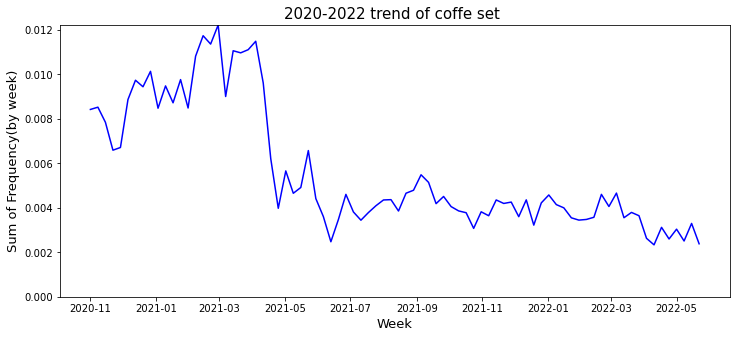

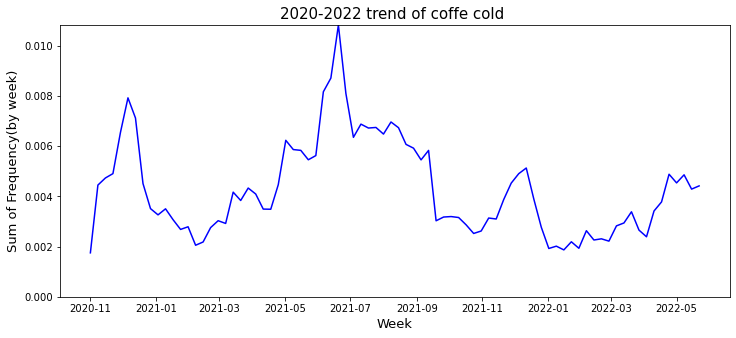

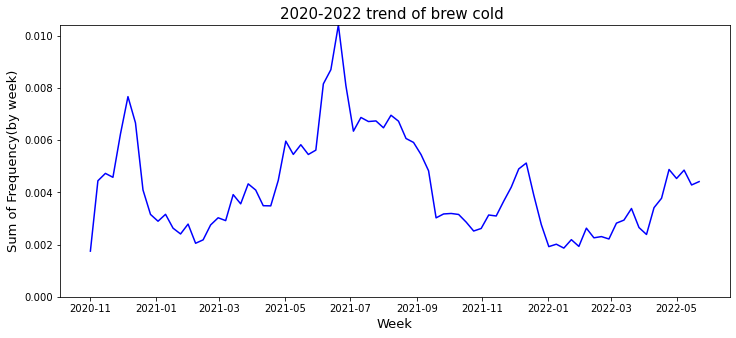

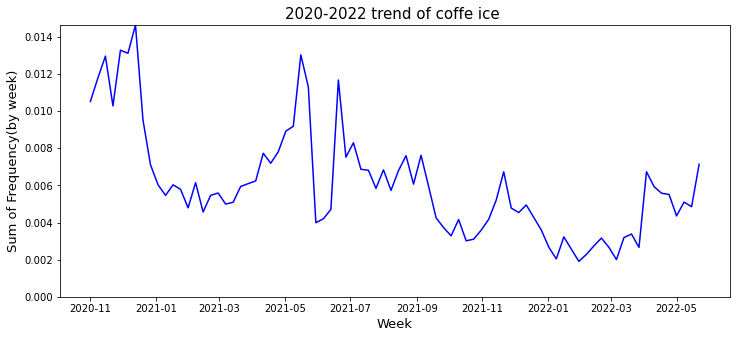

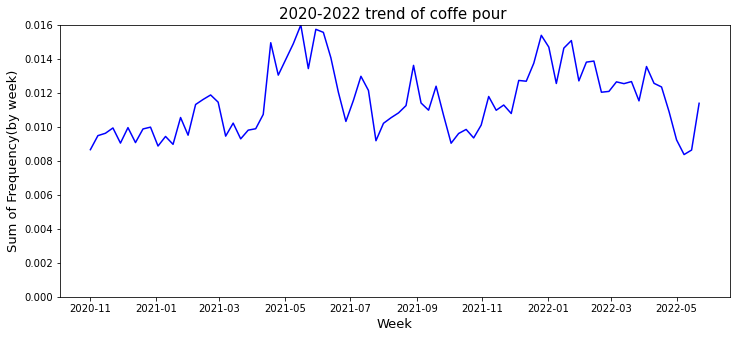

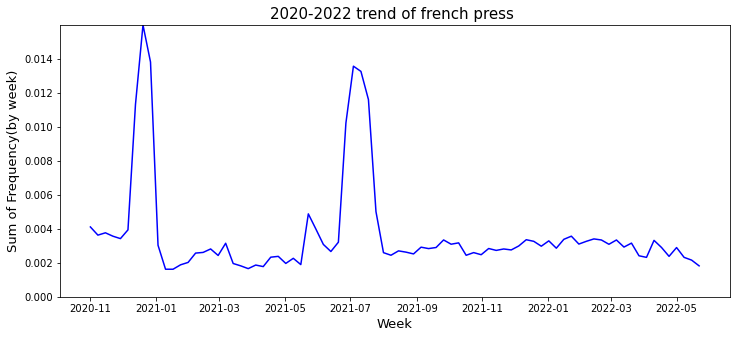

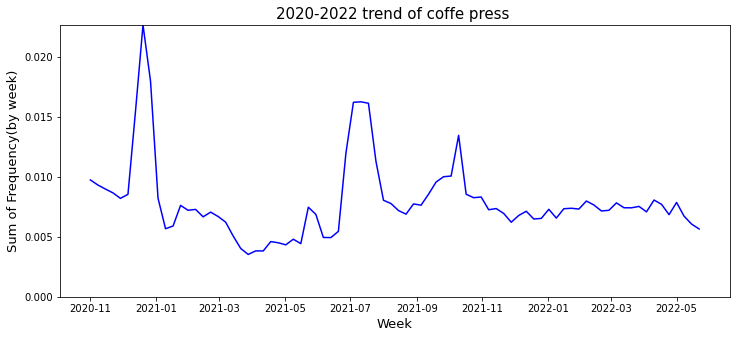

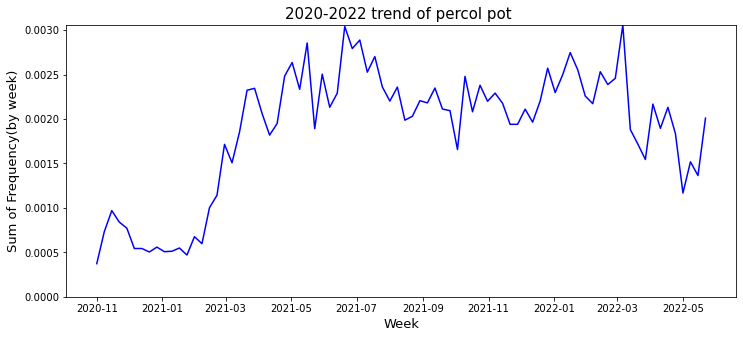

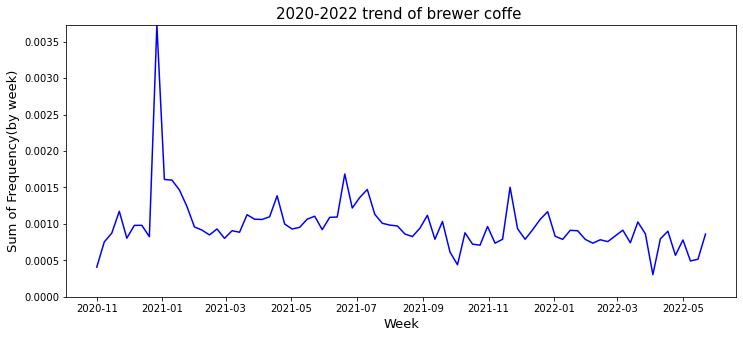

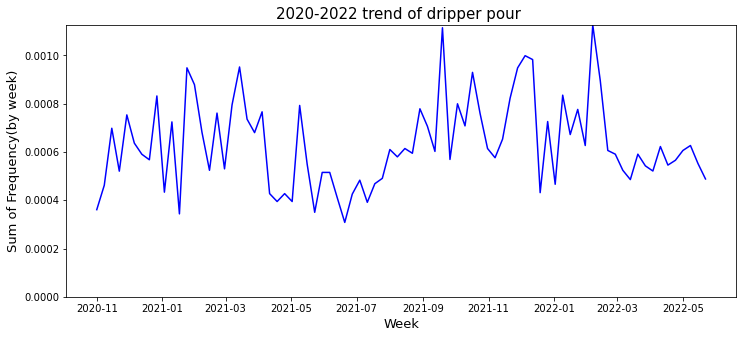

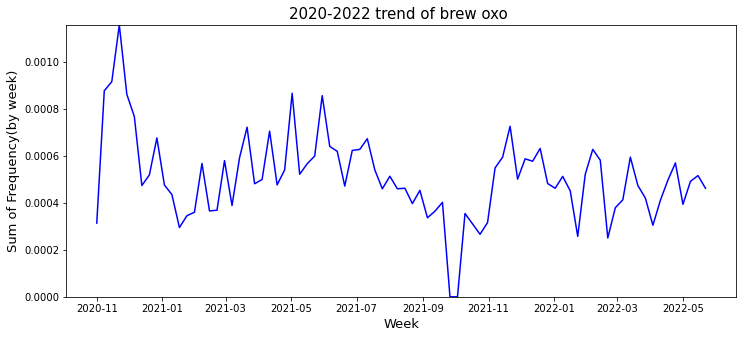

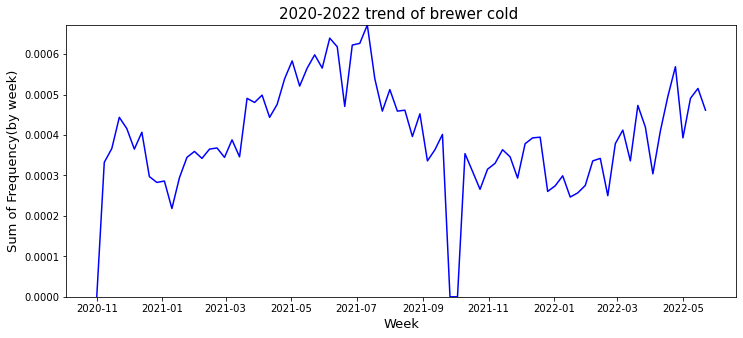

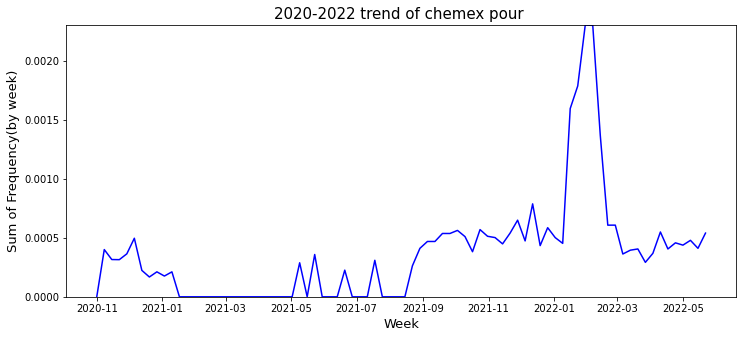

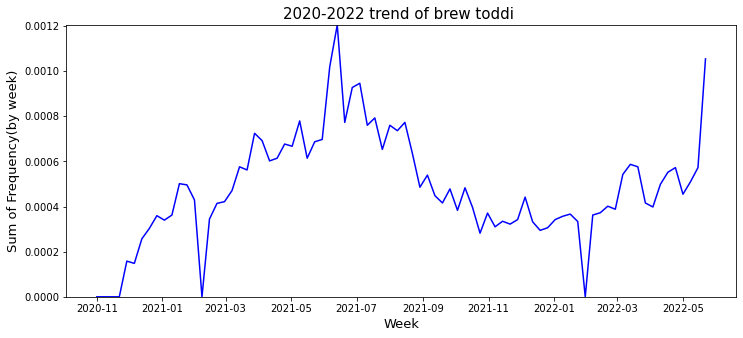

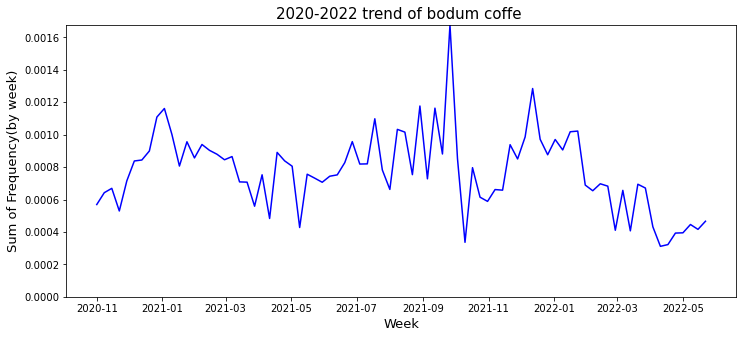

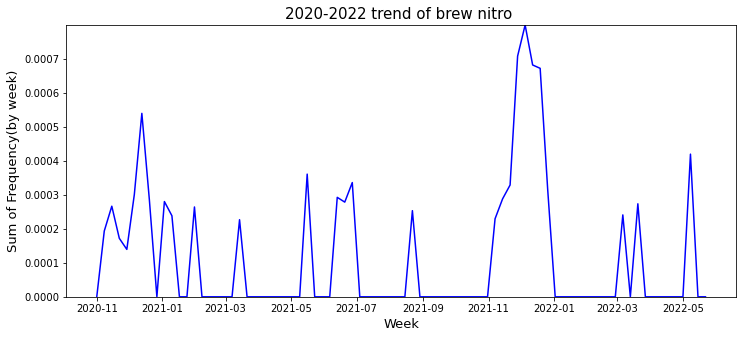

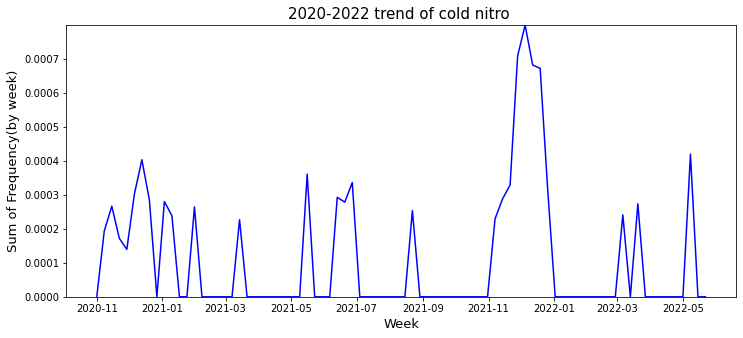

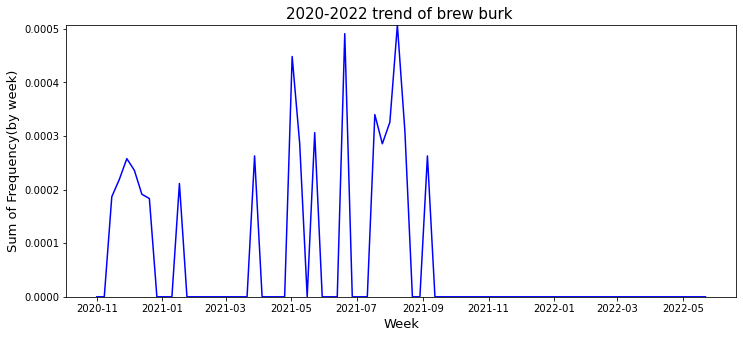

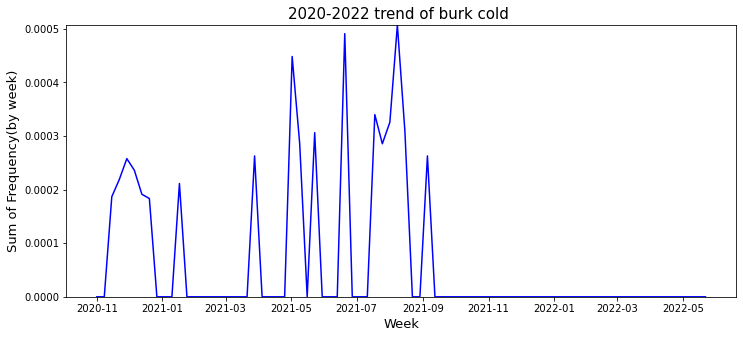

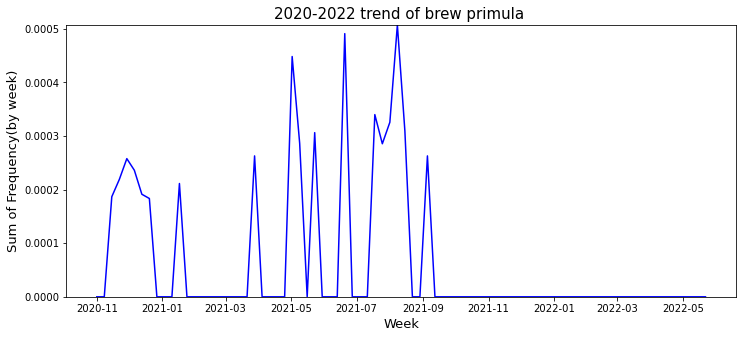

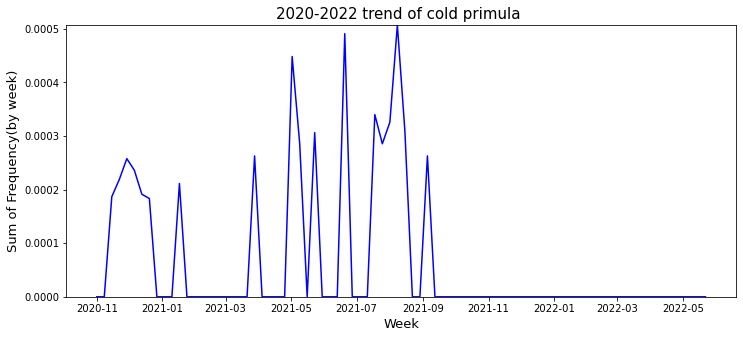

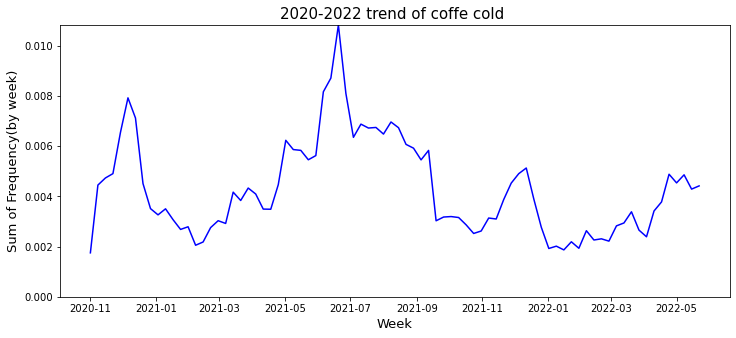

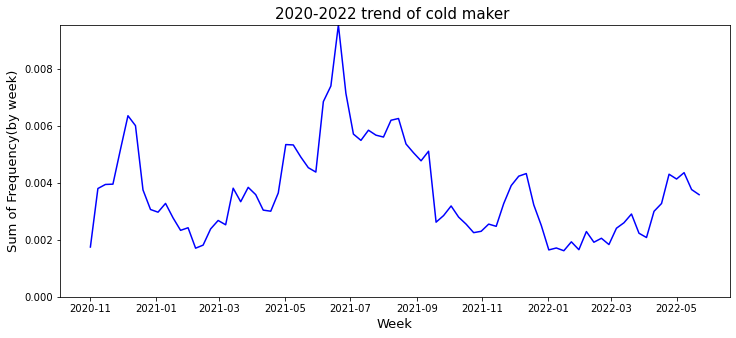

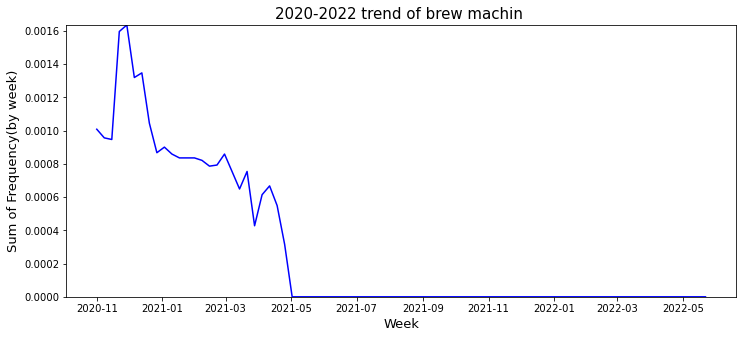

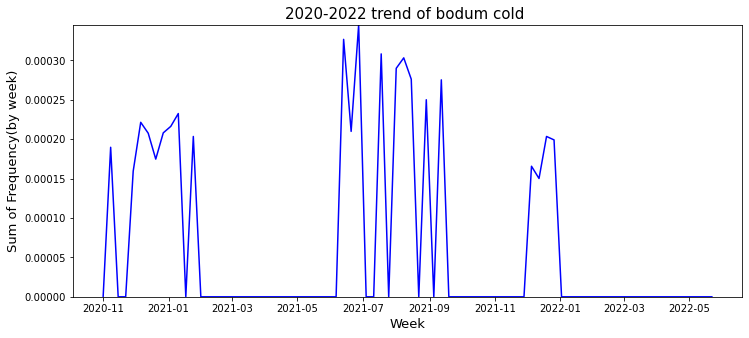

In [785]:
# Plot all Bigrams from 2020-2022 individually
for i in range(len(df_1)):
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot( df_1[i]['Date'], df_1[i]['Frequency'],'b')
    ax.set_title("2020-2022 trend of %s "%max(df_[i]["Stemmed_Bigram"]), fontsize=15)
    ax.set_ylabel('Sum of Frequency(by week)', fontsize=13)
    ax.set_xlabel('Week', fontsize=13)
    ax.set_ylim([0,max(df_1[i]["Frequency"])])

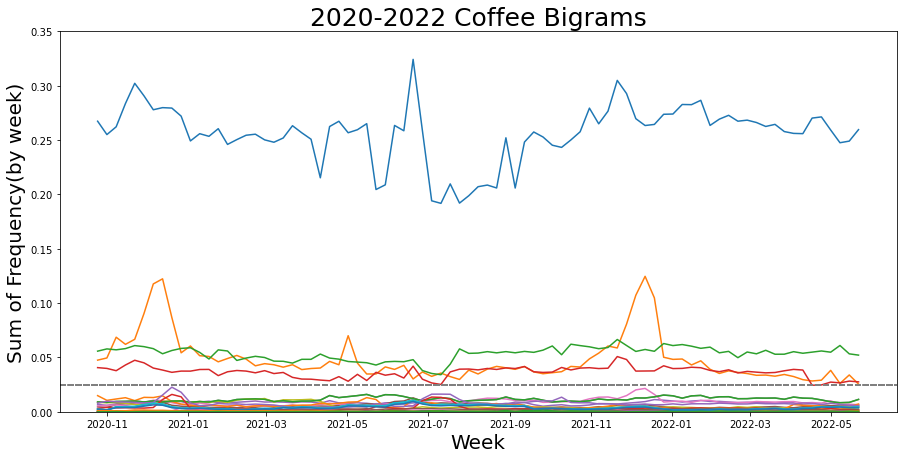

In [593]:
# Plot all Bigrams from 2020-2022 on the same scale
for i in range(len(df_1)):
    plt.figure(num = 10,figsize=(15,7))
    plt.plot( df_1[i]['Date'], df_1[i]['Frequency'],label = r"%s "%max(df_1[i]["Stemmed_Bigram"]))
    plt.title("2020-2022 Coffee Bigrams", fontsize=25)
    plt.xlabel('Week', fontsize=20)
    plt.ylabel('Sum of Frequency(by week)', fontsize=20)
    # set the threshold to be 0.025
    plt.axhline(y = 0.025, color = 'grey', linestyle = '--', label='thresholds')
    plt.ylim([0,0.35])

### 3.2 Detect Patterns
### 3.2.1 Pattern1: Set threshold: Sum of frequency > = 0.02

In [594]:
df_1_pattern1 = [pattern1(df_1[i]["Frequency"].tolist(),0.025) for i in range(len(df_1))]
df_1_pattern1

['√',
 '√',
 '√',
 '√',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']

### 3.2.2 Pattern2: Notable Trend 

In [595]:
# Calculate the Frequency_diff Dataframe
for i in range(len(df_1)):
    df_1[i]["Freq_Mean"] = df_1[i]["Frequency"].mean()
    df_1[i]["Freq_Lag"] = df_1[i]['Frequency'].shift(1)
    df_1[i]["Freq_Diff"] = pd.DataFrame(df_1[i]["Frequency"]-df_1[i]["Freq_Lag"])
    df_1[i]["Freq_Diff_Std"] = pp.scale(df_1[i]["Freq_Diff"]) #standardize
    df_1[i] = df_1[i].iloc[1:]  #delete first row(no difference value)
    
# divide all bigrams into 3 categories:
def mark(a): 
    if a > 1:
        return '+'
    elif a <= -1:
        return '-'
    else:
        return 'o'
    
df_mark = [(df_1[i].apply(lambda x: mark(x['Freq_Diff_Std']),axis=1))for i in range(len(df_1))]

for i in range(len(df_)):
    df_1[i]["Label"] = df_mark[i]

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/3231552108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[i]["Freq_Mean"] = df_1[i]["Frequency"].mean()
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/3231552108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[i]["Freq_Lag"] = df_1[i]['Frequency'].shift(1)
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/3231552108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [596]:
df_1_pattern2 = [pattern2(df_1[i]['Label'].tolist()) for i in range(len(df_1))]
df_1_pattern2

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

### 3.2.3 Pattern3: Declining Trend

In [597]:
# Calculate Coefficient, R squared, and Correlation
lst1 = []
for i in range(len(df_)):
    
    lst = []
    x = np.array([i for i in range(len(df_[i]))]).reshape(-1,1)
    y = df_[i]["Frequency"].values.reshape(-1,1)
    y.flatten()
    
    lst.append(max(df_[i]["Stemmed_Bigram"]))
    model = LinearRegression()
    model.fit(x,y)
    
    Coefficient = model.coef_
    Coefficient = round(float(Coefficient),6)
    lst.append(Coefficient)
    
#     Coefficient_std = Coefficient/ df_[i]["Frequency"].mean()
#     lst.append(Coefficient_std)
    
    Intercept = model.intercept_
    Intercept = round(float(Intercept),4)
    lst.append(Intercept)
    
    R_Square = model.score(x,y)
    R_Square = round(float(R_Square),4)
    lst.append(R_Square)
    
    corr,p = spearmanr(x,y)
    lst.append(corr)
    lst.append(p)
    
    lst1.append(lst)

df_1_1 = pd.DataFrame(lst1, columns = ["Bigram","Coefficient",'Intercept',"R_Square","Correlation","P_Value"]).round(6)
df_1_1

,Bigram,Coefficient,Intercept,R_Square,Correlation,P_Value
0,coffe maker,0.000059,0.2536,0.0030,0.105705,0.341563
1,coffe mug,-0.000291,0.0600,0.1092,-0.539419,0.000000
2,coffe grinder,0.000061,0.0511,0.0563,0.197011,0.074233
3,coffe machin,-0.000030,0.0378,0.0189,-0.089837,0.419278
4,coffe glass,-0.000008,0.0082,0.0197,-0.134020,0.227076
5,brew coffe,-0.000024,0.0067,0.0963,-0.318542,0.003336
6,mug travel,0.000054,0.0066,0.1824,0.492528,0.000002
7,coffe pour,0.000027,0.0104,0.1068,0.364552,0.000703
8,coffe set,-0.000091,0.0094,0.6144,-0.794635,0.000000
9,coffe cold,-0.000017,0.0050,0.0487,-0.221863,0.043820


In [598]:
df_1_pattern3 = df_1_1.apply(lambda x: pattern3(x['Coefficient'],x['Intercept'],x['P_Value'],x['R_Square']),axis=1)
df_1_pattern3

0      
1      
2      
3      
4      
5      
6      
7      
8     √
9      
10     
11    √
12     
13     
14     
15     
16     
17     
18     
19     
20     
21     
22     
23     
24     
25     
26     
27     
28     
29     
30     
31    √
32     
dtype: object

### 3.2.4 Pattern4: Peak Trend

In [599]:
df_1_pattern4 = [pattern4(df_1[i]["Frequency"],df_1[i]['Freq_Mean']) for i in range(len(df_1))]
df_1_pattern4

['',
 '',
 '',
 '',
 '',
 '√',
 '√',
 '',
 '',
 '√',
 '√',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '√',
 '√',
 '',
 '',
 '',
 '',
 '',
 '',
 '√',
 '√',
 '',
 '']

### 3.2.5 Trend DataFrame

In [783]:
Pattern_20_22 = pd.DataFrame({"Bigram":df_1_1["Bigram"],"Pattern1": df_1_pattern1,"Pattern2": df_1_pattern2,"Pattern3":df_1_pattern3,"Pattern4":df_1_pattern4})
# Pattern_20_22.head(10)
Pattern_20_22

,Bigram,Pattern1,Pattern2,Pattern3,Pattern4
0,coffe maker,√,,,
1,coffe mug,√,,,
2,coffe grinder,√,,,
3,coffe machin,√,,,
4,coffe glass,,,,
5,brew coffe,,,,√
6,mug travel,,,,√
7,coffe pour,,,,
8,coffe set,,,√,
9,coffe cold,,,,√


### 4. Year 2022

### 4.1 Plot Trendlines

In [791]:
# filter out all chosen bigrams of 2022
df_2 = [df_coffee[ (df_coffee['Stemmed_Bigram'] == bigrams[i]) & (df_coffee['Date'] > "2021-12-31")] for i in range(len(bigrams))]
df_2

[             Date Stemmed_Bigram  Frequency
 202131 2022-01-02    coffe maker   0.273892
 205370 2022-01-09    coffe maker   0.282661
 208609 2022-01-16    coffe maker   0.282506
 211848 2022-01-23    coffe maker   0.286503
 215087 2022-01-30    coffe maker   0.263411
 218326 2022-02-06    coffe maker   0.269179
 221565 2022-02-13    coffe maker   0.272712
 224804 2022-02-20    coffe maker   0.267292
 228043 2022-02-27    coffe maker   0.268267
 231282 2022-03-06    coffe maker   0.266087
 234521 2022-03-13    coffe maker   0.262450
 237760 2022-03-20    coffe maker   0.264375
 240999 2022-03-27    coffe maker   0.257757
 244238 2022-04-03    coffe maker   0.256078
 247477 2022-04-10    coffe maker   0.255830
 250716 2022-04-17    coffe maker   0.270164
 253955 2022-04-24    coffe maker   0.271241
 257194 2022-05-01    coffe maker   0.259176
 260433 2022-05-08    coffe maker   0.247487
 263672 2022-05-15    coffe maker   0.248981
 266911 2022-05-22    coffe maker   0.259538,
         

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/479355078.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,3))
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/479355078.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0,max(df_2[i]["Frequency"])])
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/479355078.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0,max(df_2[i]["Frequency"])])
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/479355078.py:8: UserWarning: Attempting to set i

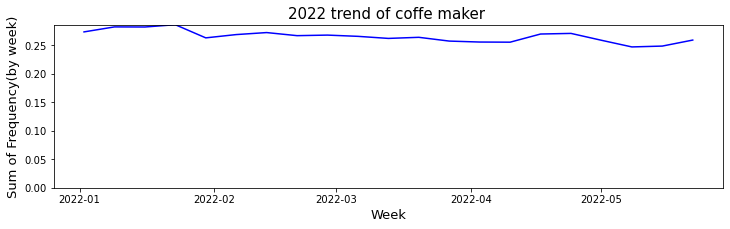

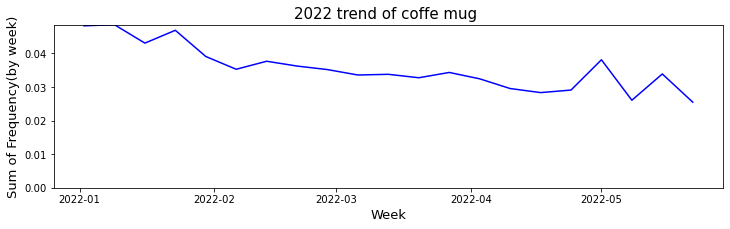

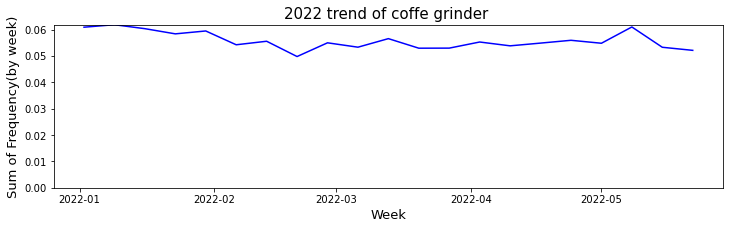

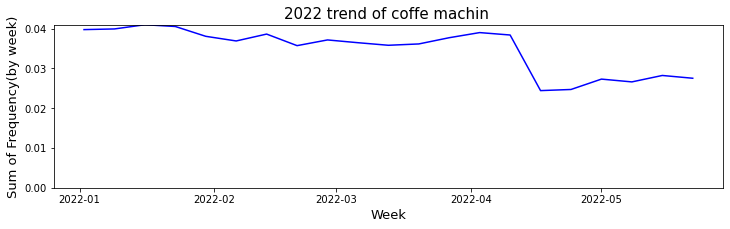

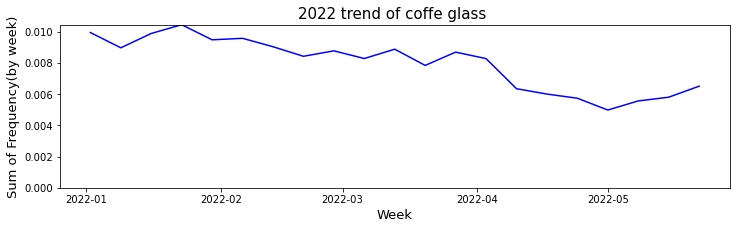

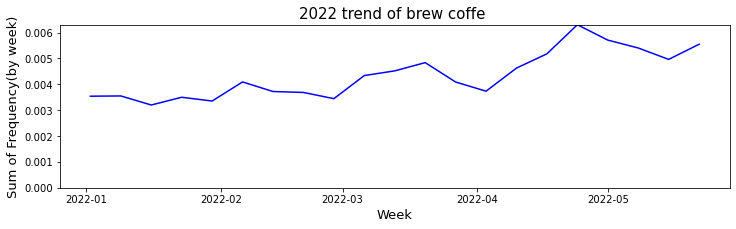

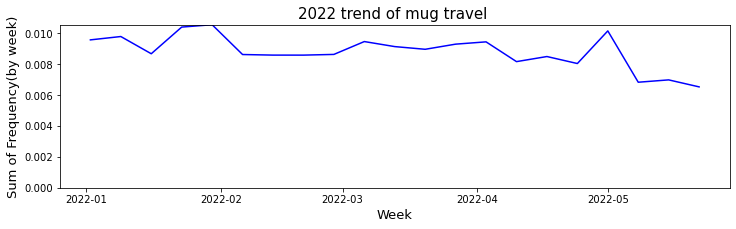

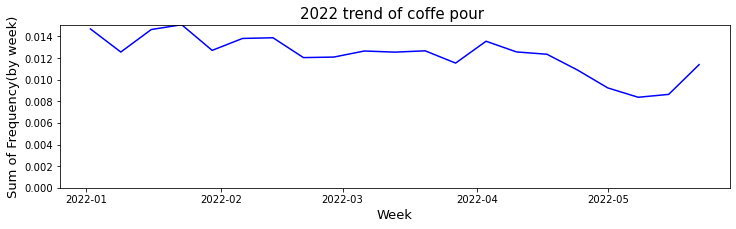

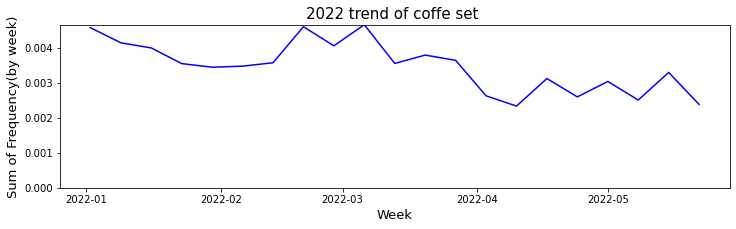

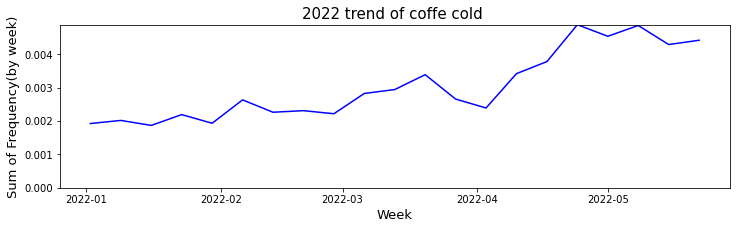

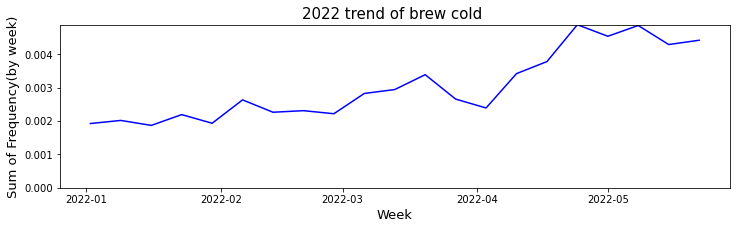

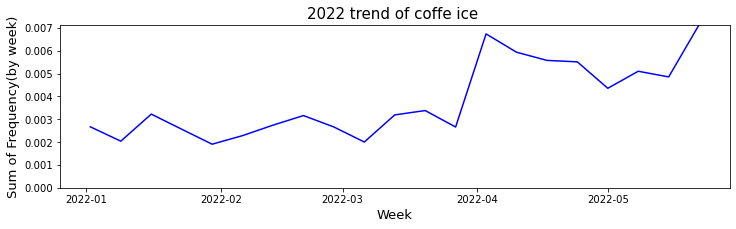

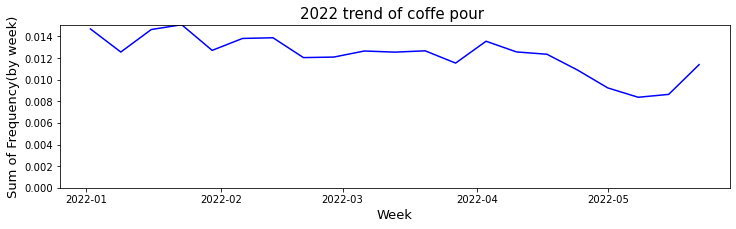

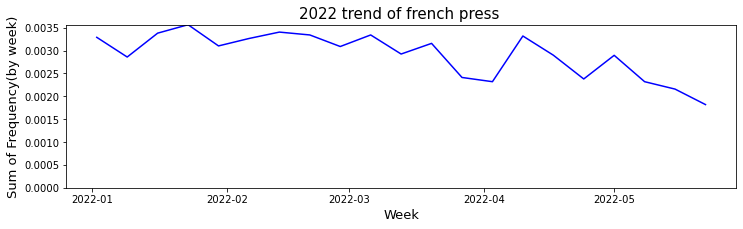

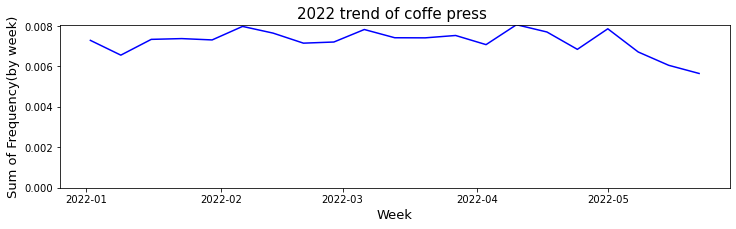

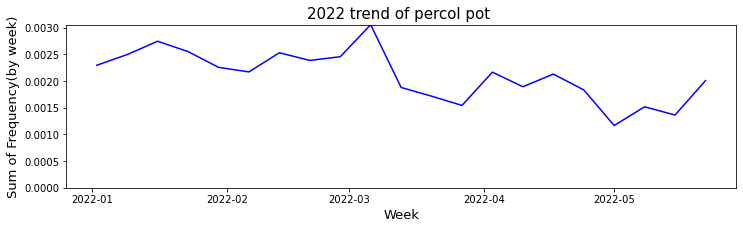

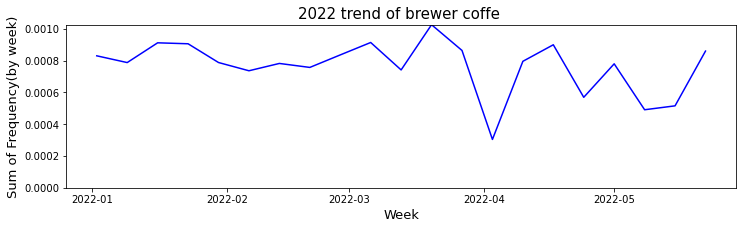

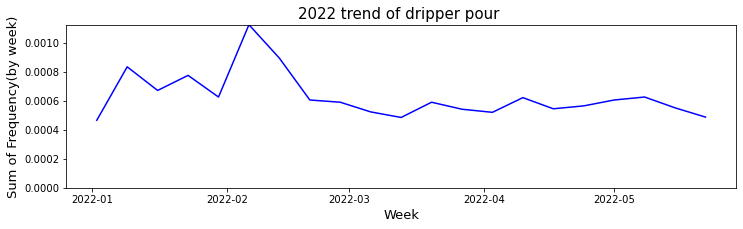

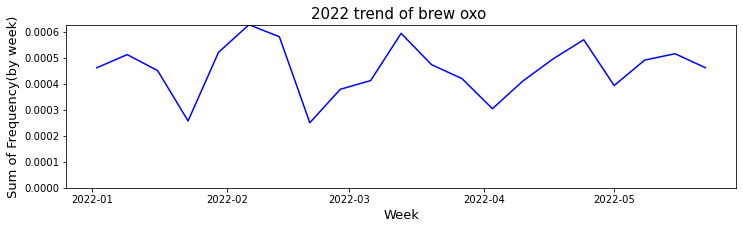

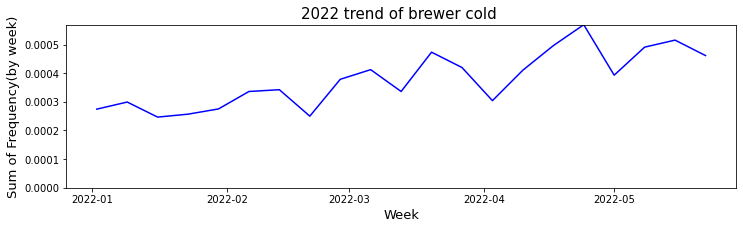

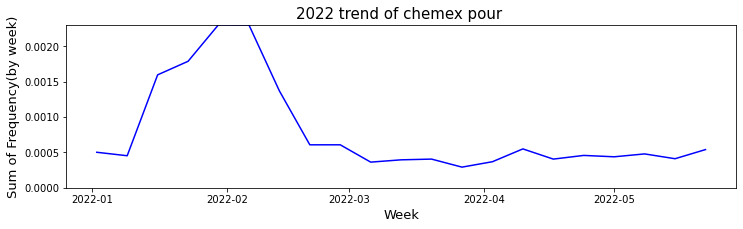

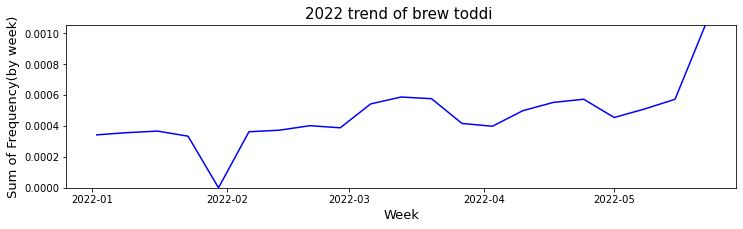

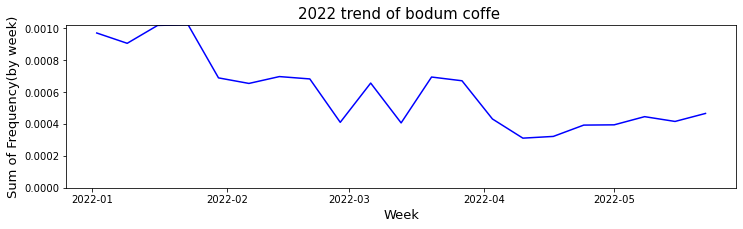

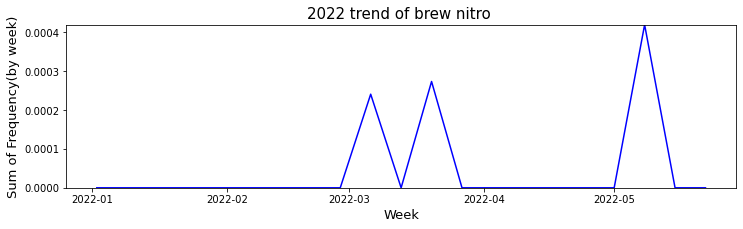

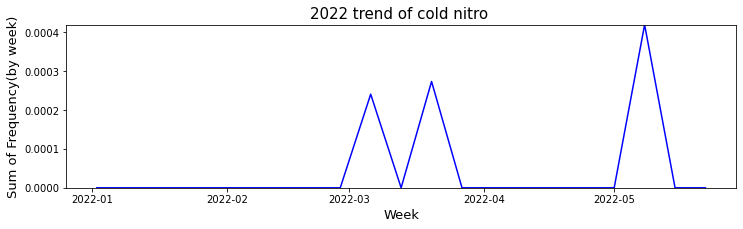

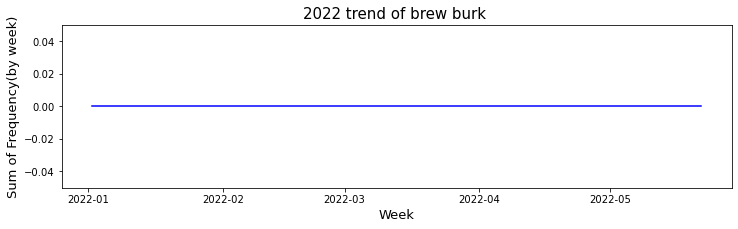

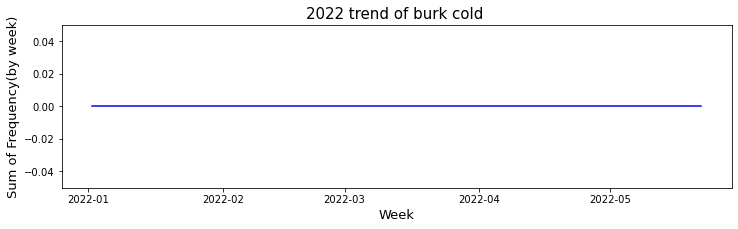

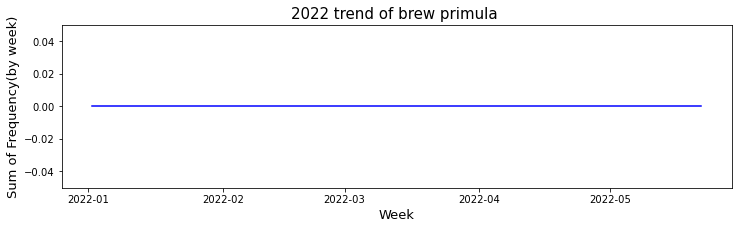

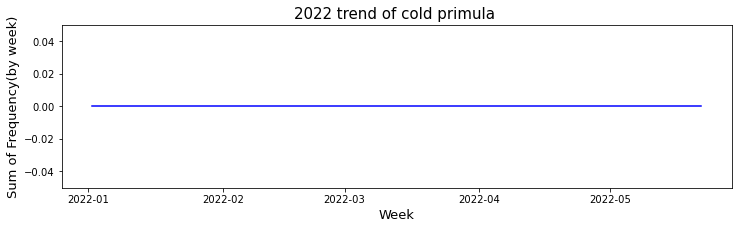

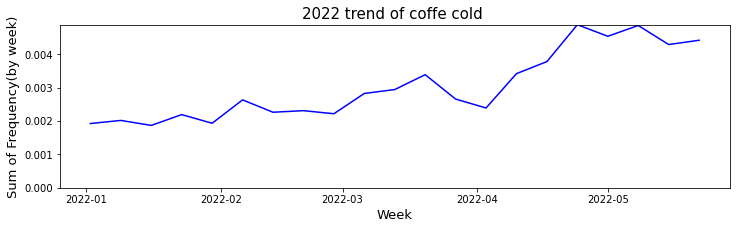

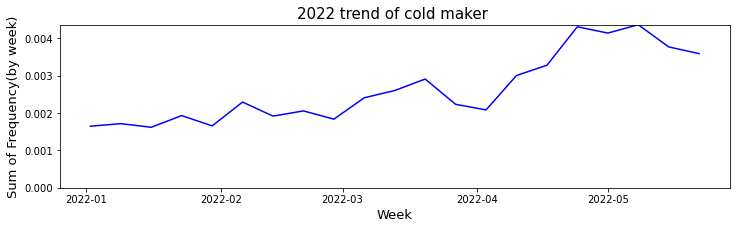

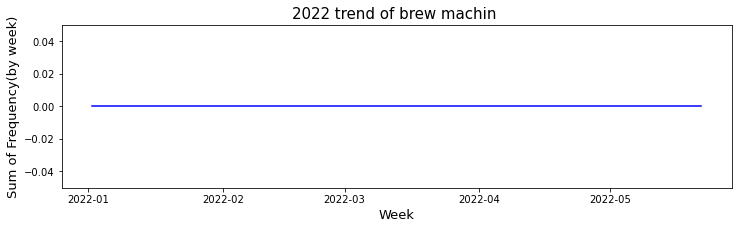

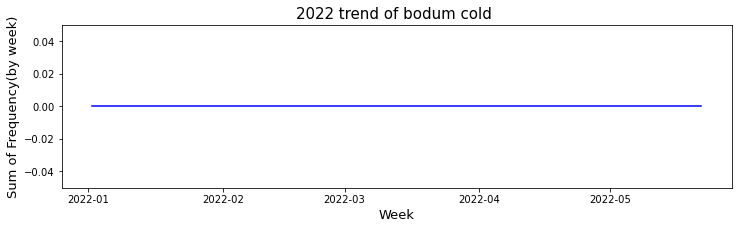

In [792]:
# Plot all Bigrams individually
for i in range(len(df_2)):
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot( df_2[i]['Date'], df_2[i]['Frequency'],'b')
    ax.set_title("2022 trend of %s "%max(df_2[i]["Stemmed_Bigram"]), fontsize=15)
    ax.set_ylabel('Sum of Frequency(by week)', fontsize=13)
    ax.set_xlabel('Week', fontsize=13)
    ax.set_ylim([0,max(df_2[i]["Frequency"])])

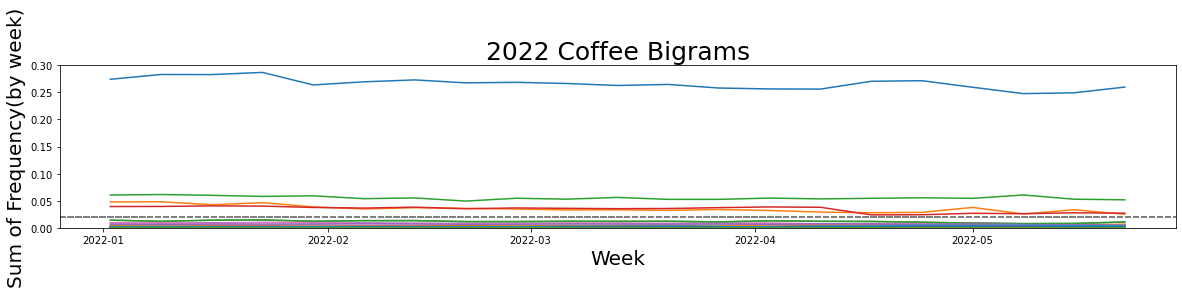

In [292]:
# Plot all Bigrams on the same scale
for i in range(len(df_2)):
    plt.figure(num = 10,figsize=(20,3))
    plt.plot( df_2[i]['Date'], df_2[i]['Frequency'],label = r"%s "%max(df_2[i]["Stemmed_Bigram"]))
    plt.title("2022 Coffee Bigrams", fontsize=25)
    plt.xlabel('Week', fontsize=20)
    plt.ylabel('Sum of Frequency(by week)', fontsize=20)
    plt.axhline(y = 0.02, color = 'grey', linestyle = '--', label='thresholds') # set the threshold as 0.02
    plt.ylim([0,0.3])

### 4.2 Detect Patterns
### 4.2.1 Pattern1: Set threshold: Sum of frequency > = 0.02

In [602]:
df_2_pattern1 = [pattern1(df_2[i]["Frequency"].tolist(),0.02) for i in range(len(df_2))]
df_2_pattern1

['√',
 '√',
 '√',
 '√',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']

### 4.2.2 Pattern2: Notable Trend

In [603]:
# Calculate the Frequency_diff Dataframe
for i in range(len(df_2)):
    df_2[i]["Freq_Mean"] = df_2[i]["Frequency"].mean()
    df_2[i]["Freq_Lag"] = df_2[i]['Frequency'].shift(1)
    df_2[i]["Freq_Diff"] = pd.DataFrame(df_2[i]["Frequency"]-df_2[i]["Freq_Lag"])
    df_2[i]["Freq_Diff_Std"] = pp.scale(df_2[i]["Freq_Diff"]) #standardize
    df_2[i] = df_2[i].iloc[1:]  #delete first row(no difference value)

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/3536840453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[i]["Freq_Mean"] = df_2[i]["Frequency"].mean()
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/3536840453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[i]["Freq_Lag"] = df_2[i]['Frequency'].shift(1)
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_53692/3536840453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [604]:
# divide all bigrams into 3 categories:
def mark(a): 
    if a > 1:
        return '+'
    elif a <= -1:
        return '-'
    else:
        return 'o'
    
df_mark1 = [(df_2[i].apply(lambda x: mark(x['Freq_Diff_Std']),axis=1))for i in range(len(df_2))]
df_mark1

for i in range(len(df_2)):
    df_2[i]["Label"] = df_mark1[i]  

In [485]:
df_2[0]

,Date,Stemmed_Bigram,Frequency,Freq_Mean,Freq_Lag,Freq_Diff,Freq_Diff_Std,Label
205370,2022-01-09,coffe maker,0.282661,0.26598,0.273892,0.008769,1.149256,+
208609,2022-01-16,coffe maker,0.282506,0.26598,0.282661,-0.000155,0.068125,o
211848,2022-01-23,coffe maker,0.286503,0.26598,0.282506,0.003997,0.571180,o
215087,2022-01-30,coffe maker,0.263411,0.26598,0.286503,-0.023092,-2.710501,-
218326,2022-02-06,coffe maker,0.269179,0.26598,0.263411,0.005768,0.785683,o
221565,2022-02-13,coffe maker,0.272712,0.26598,0.269179,0.003533,0.514906,o
224804,2022-02-20,coffe maker,0.267292,0.26598,0.272712,-0.005420,-0.569641,o
228043,2022-02-27,coffe maker,0.268267,0.26598,0.267292,0.000975,0.205110,o
231282,2022-03-06,coffe maker,0.266087,0.26598,0.268267,-0.002181,-0.177226,o
234521,2022-03-13,coffe maker,0.262450,0.26598,0.266087,-0.003637,-0.353634,o


In [749]:
df_2_pattern2 = [pattern2(df_2[i]['Label'].tolist()) for i in range(len(df_2))]
df_2_pattern2

['',
 '',
 '√',
 '',
 '√',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '√',
 '√',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '√',
 '',
 '']

### 4.2.3 Pattern3: Declining Trend

In [606]:
lst2 = []

for i in range(len(df_2)):
    lst_ = []
    
    x = np.array([i for i in range(len(df_2[i]))]).reshape(-1,1)
    y = df_2[i]["Frequency"].values.reshape(-1,1)
    y.flatten()
    lst_.append(max(df_2[i]["Stemmed_Bigram"]))
    
    model = LinearRegression()
    model.fit(x,y)
    
    Coefficient = model.coef_
    Coefficient = round(float(Coefficient),5)  #should tuning the digits
    lst_.append(Coefficient)
    
    Intercept = model.intercept_
    Intercept = round(float(Intercept),4)
    lst_.append(Intercept)
    
    R_Square = model.score(x,y)
    R_Square = round(float(R_Square),4)
    lst_.append(R_Square)
    
    corr,p = spearmanr(x,y)
    lst_.append(corr)
    lst_.append(p)
     
    lst2.append(lst_)

df_2_1 = pd.DataFrame(lst2, columns = ["Bigram","Coefficient",'Intercept',"R_Square","Correlation","P_Value"]).round(4)
df_2_1

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.p

,Bigram,Coefficient,Intercept,R_Square,Correlation,P_Value
0,coffe maker,-0.0014,0.2785,0.5930,-0.7098,0.0005
1,coffe mug,-0.0008,0.0430,0.6666,-0.7955,0.0000
2,coffe grinder,-0.0002,0.0577,0.1633,-0.4165,0.0677
3,coffe machin,-0.0008,0.0419,0.6600,-0.7504,0.0001
4,coffe glass,-0.0002,0.0103,0.8066,-0.9053,0.0000
5,brew coffe,0.0001,0.0032,0.7222,0.8737,0.0000
6,mug travel,-0.0001,0.0099,0.3950,-0.5940,0.0058
7,coffe pour,-0.0002,0.0144,0.5797,-0.7594,0.0001
8,coffe set,-0.0001,0.0042,0.4632,-0.6917,0.0007
9,coffe cold,0.0002,0.0016,0.8048,0.9158,0.0000


In [607]:
df_2_pattern3 = df_2_1.apply(lambda x: pattern3(x['Coefficient'],x['Intercept'],x['P_Value'],x['R_Square']),axis=1)
df_2_pattern3

0     √
1     √
2      
3     √
4     √
5      
6     √
7     √
8     √
9      
10     
11     
12    √
13    √
14     
15    √
16     
17     
18     
19     
20    √
21     
22     
23     
24     
25     
26     
27     
28     
29     
30     
31     
32     
dtype: object

### 4.2.4 Pattern4: Peak Trend

In [653]:
df_2_pattern4 = [pattern4(df_2[i]["Frequency"],df_2[i]['Freq_Mean']) for i in range(len(df_2))]
df_2_pattern4

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

### 4.2.5 Trend DataFrame

In [781]:
Pattern_22 = pd.DataFrame({"Bigram":df_2_1["Bigram"],"Pattern1": df_2_pattern1,"Pattern2": df_2_pattern2,"Pattern3":df_2_pattern3,"Pattern4":df_2_pattern4})
Pattern_22

,Bigram,Pattern1,Pattern2,Pattern3,Pattern4
0,coffe maker,√,,√,
1,coffe mug,√,,√,
2,coffe grinder,√,√,,
3,coffe machin,√,,√,
4,coffe glass,,√,√,
5,brew coffe,,,,
6,mug travel,,,√,
7,coffe pour,,,√,
8,coffe set,,,√,
9,coffe cold,,,,
